## Real Spacers sequence features
(See fetch_real_data.ipynb prior to this notebook for getting and indexing the actual spacers).  

In our benchmark, we'll use the CRISPR sapcer set from iphop [https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions](https://bitbucket.org/srouxjgi/iphop/src/main/#markdown-header-host-databases-and-versions) (June 2025 upload).  
Despite being considered as a more curated set compared to the IMG/VR4 set (e.g. the size range is 25-50, with no spacers over 100bp), we will still inspect it for potential issues.  
Doing this we can also get an idea on the features of real spacers:
-  low complexity sequences (low shannon entropy, low lcc value, presence of dustmasked/ambiguous bases...)
-  Relative base composition
-  distribution of kmers (uniqueness and repeatability, 2<= k <= 6)
-  per position base frequency

Using these features, we can filter out certain sequences that some tools (like iphop) would have filter out in post-processing (after spacer-protospacer matching). While some tools have defaults and heuristics to filter out low complexity or repetitive sequences, so by doing this prior to the benchmark we are potentially skewing the results in favor of tools that do not have these filters (although some tools were specifically benchmarked with CLI options to avoid these filters - e.g. the blastn "short" task has dust filtering turned off by default).  
These low quality spacers could be the results of the extraction tools (like pilercr and CRT) misdetecting non-CRISPR repeat sequences, or potentially not extracting the sequences correctly.


In [77]:
import os
os.chdir('/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/imgvr4_data/')
import json
import polars as pl
import pydustmasker as pdm
import matplotlib.pyplot as plt
import seaborn as sns
from bench import *
from bench.utils.functions import  read_fasta_needletail, calculate_shannon_entropy, count_kmers_df, lcc_simp, lcc_mult, filter_repetitive_kmers

pl.Config(tbl_rows=50)
plots_dir = '/clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/'
# Load your custom color palette
with open('../notebooks/antonio_14_colors.json', 'r') as f:
    color_data = json.load(f)
# Set the color palette globally
custom_colors = color_data['hex_colors']
sns.set_palette(custom_colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
    
spacers_file = 'spacers/All_CRISPR_spacers_nr_clean.fna'
spacer_df = pl.DataFrame(read_fasta_needletail(spacers_file), schema={'seqid': pl.Utf8, 'seq': pl.Utf8},)
spacer_df = spacer_df.with_columns(
    pl.col("seq").str.len_chars().alias("length")
    )
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("G|C|g|c")/pl.col("length")).alias("gc_frac"))

### Some basics
First, let's see the total size of the set and the ranges of lengths and GC content.

Total number of spacers: 3882812
Length range: 25 - 40
Length mean: 33.85102008544323
GC content range: 0.025 - 0.9743589743589743
GC content mean: 0.476438028374395


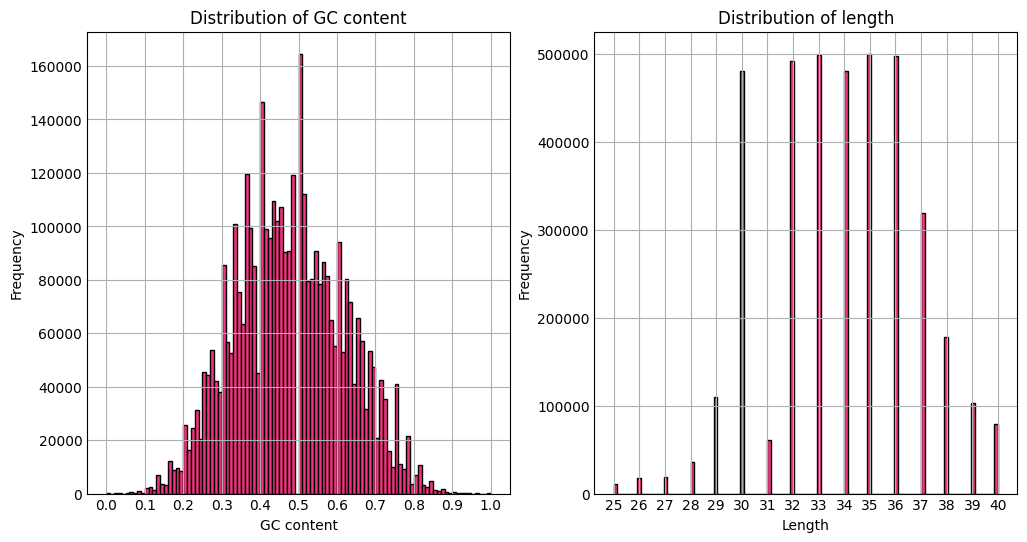

In [78]:
print(f"Total number of spacers: {spacer_df.height}")
print(f"Length range: {spacer_df['length'].min()} - {spacer_df['length'].max()}")
print(f"Length mean: {spacer_df['length'].mean()}")
print(f"GC content range: {spacer_df.filter(pl.col('gc_frac') > 0)['gc_frac'].min()} - {spacer_df.filter(pl.col('gc_frac') != 1)['gc_frac'].max()}")
print(f"GC content mean: {spacer_df.filter(pl.col('gc_frac') > 0)['gc_frac'].mean()}")
spacer_df["gc_frac"].describe()
# quick plots   - two panels, one for the GC content and one for the length
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(spacer_df["gc_frac"], bins=100, edgecolor='black')
axes[0].set_title('Distribution of GC content')
axes[0].set_xlabel('GC content')
axes[0].set_ylabel('Frequency')
axes[1].hist(spacer_df["length"], bins=100, edgecolor='black')
axes[1].set_title('Distribution of length')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')
# show grid
axes[0].grid(True)
axes[1].grid(True)
# show ticks for all x values
axes[0].set_xticks(np.arange(0, 1.01, 0.1))
axes[1].set_xticks(spacer_df["length"].unique())
# show ticks labels
axes[0].tick_params(axis='both', which='both', length=0)
axes[1].tick_params(axis='both', which='both', length=0)
plt.savefig(plots_dir + 'gc_length_distributions.svg')
plt.show()

### Relative base composition of the spacers (fraction of the each base out of the total number of bases in each spacer).

In [79]:
spacer_df = spacer_df.with_columns(
    (pl.col("seq").str.count_matches("N|n")/pl.col("length")).alias("n_frac"),
    (pl.col("seq").str.count_matches("A|a")/pl.col("length")).alias("a_frac"),
    (pl.col("seq").str.count_matches("T|t")/pl.col("length")).alias("t_frac"),
    (pl.col("seq").str.count_matches("C|c")/pl.col("length")).alias("c_frac"),
    (pl.col("seq").str.count_matches("G|g")/pl.col("length")).alias("g_frac"),
)
# spacer_df = spacer_df.sort("t_frac", descending=True)

### Plots 

a_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.261702   │
│ std        ┆ 0.107613   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.181818   │
│ 50%        ┆ 0.25       │
│ 75%        ┆ 0.333333   │
│ max        ┆ 1.0        │
└────────────┴────────────┘


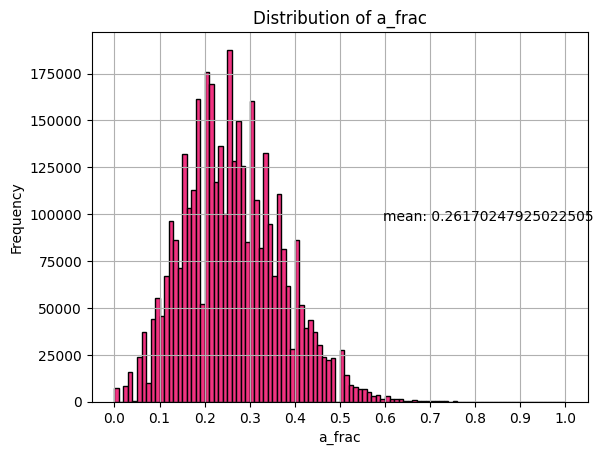

t_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.261751   │
│ std        ┆ 0.107737   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.181818   │
│ 50%        ┆ 0.25       │
│ 75%        ┆ 0.333333   │
│ max        ┆ 0.933333   │
└────────────┴────────────┘


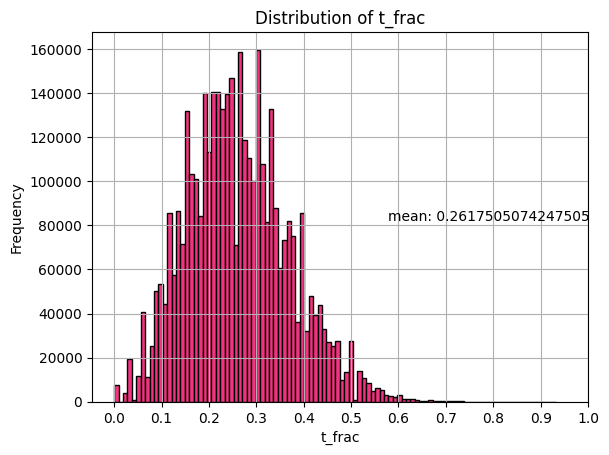

c_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.238359   │
│ std        ┆ 0.096436   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.166667   │
│ 50%        ┆ 0.233333   │
│ 75%        ┆ 0.30303    │
│ max        ┆ 0.92       │
└────────────┴────────────┘


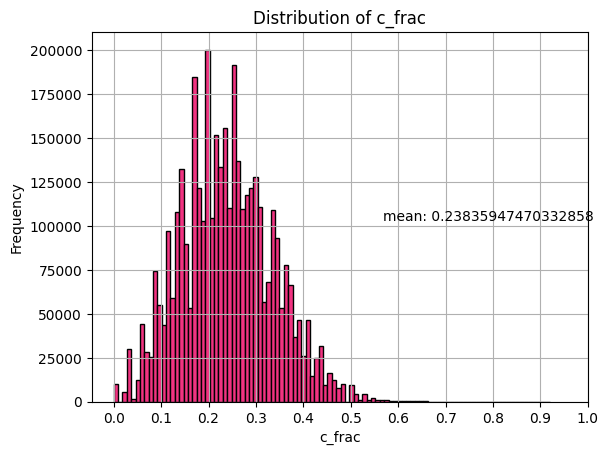

g_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.238039   │
│ std        ┆ 0.09656    │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.166667   │
│ 50%        ┆ 0.233333   │
│ 75%        ┆ 0.30303    │
│ max        ┆ 1.0        │
└────────────┴────────────┘


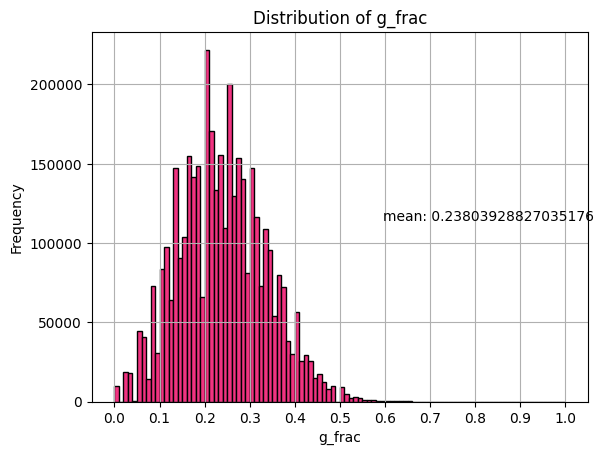

n_frac stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 3.882812e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.000147   │
│ std        ┆ 0.010133   │
│ min        ┆ 0.0        │
│ 25%        ┆ 0.0        │
│ 50%        ┆ 0.0        │
│ 75%        ┆ 0.0        │
│ max        ┆ 1.0        │
└────────────┴────────────┘


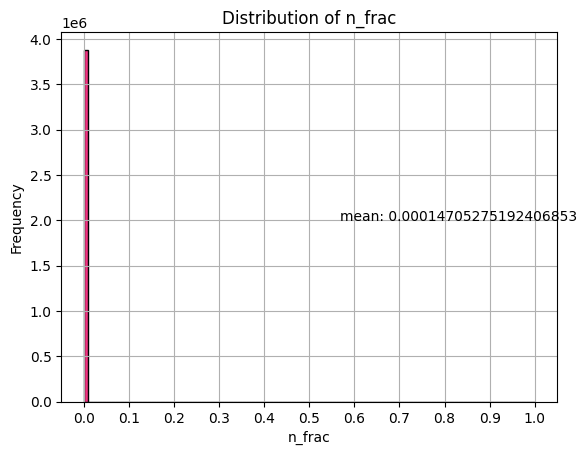

In [83]:
for base in ["a_frac", "t_frac", "c_frac", "g_frac", "n_frac"]:
    print(f"{base} stats:")
    print(spacer_df[base].describe())
    plt.hist(spacer_df[base], bins=100, edgecolor='black')
    plt.title(f'Distribution of {base}')
    # show grid
    plt.grid(True)
    plt.xticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(base)
    plt.ylabel('Frequency')
    plt.text(0.8, 0.5, f'mean: {spacer_df[base].mean()}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.savefig(plots_dir + f'{base}_distribution.svg')
    plt.show()
    plt.close()


### Ambiguous base presence
The N fraction from above is small but not 0. as a precaution, we'll mark these with a column.


In [84]:
spacer_df = spacer_df.with_columns(
    pl.when(pl.col("n_frac") > 0).then(True).otherwise(False).alias("has_n"))
spacer_df["has_n"].value_counts(normalize=True)

has_n,proportion
bool,f64
false,0.999675
true,0.000325


### Shannon entropy
Calculating the Shannon entropy of each spacer sequence.  

The Shannon entropy formula is $H = -\sum p_{i}\log _{2}p_{i}$   
where $p_{i}$ is the probability of character $i$ in the spacer sequence.


In [85]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)
spacer_df["entropy"].describe()

statistic,value
str,f64
"""count""",3.882812e6
"""null_count""",0.0
"""mean""",1.872601
"""std""",0.107339
"""min""",0.0
"""25%""",1.825323
"""50%""",1.900292
"""75%""",1.948929
"""max""",3.253259


An plotting the histogram of the entropy values to see the distribution.

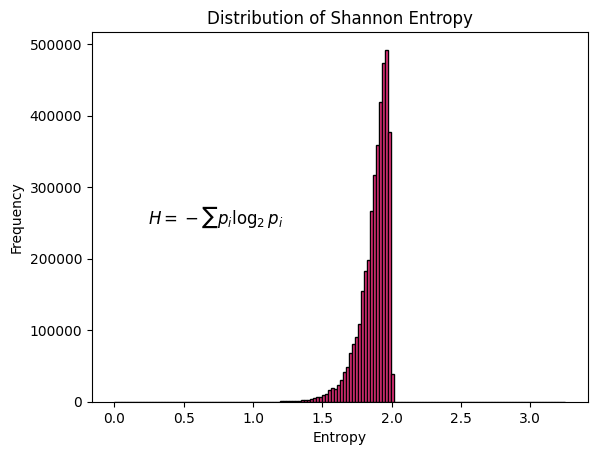

In [86]:
plt.hist(spacer_df["entropy"], bins=150, edgecolor='black')
plt.title('Distribution of Shannon Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.text(0.25, 0.5, '$H = -\sum p_{i}\log_{2} p_{i}$', ha='center', va='center', transform=plt.gca().transAxes,fontsize=12)
plt.savefig(plots_dir + 'entropy_distribution.svg')
plt.show()

### Reapeted kmer compositions
The Shannon entrophy metric doesn't take into account the base order: `aaaaaatttttttgggggcccccc` and `ccccattaaaacggcgttgtgatt` will have the same value, even thouse the first one is less complex.  
Because of this, we'll examine if the spacers contain repeatative (appearing at least twice) substrings of lengths 3-8. For the example above, if we use k=3, we get:
| seq | kmer_3_counts |
|-----|---------------|
| `aaaaaatttttttgggggcccccc` | `aat': 1,tgg: 1,ggg: 3,aaa: 4,ttg: 1,ccc: 4,ttt: 5,gcc: 1,att: 1,ggc: 1` |
| `ccccattaaaacggcgttgtgatt` | `gtt': 2,ttt: 1,ata: 1,tcc: 1,aca: 2,cag: 1,cta: 1,ccc: 1,tgg: 1,agt: 1,cca: 1,agc: 1,cat: 1,ttg: 1,gct: 1,cac: 1,gac: 1,ttc: 1,gga: 1,tag: 1` |
  
And the mean of the counts for the first is:
$\frac{1 + 1 + 3 + 4 + 1 + 4 + 5 + 1 + 1 + 1}{10} = \frac{22}{10} = 2.2$  
And for the second:
$\frac{2 + 1 + 1 + 1 + 2 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1}{19} = \frac{22}{19} = 1.15781.157895$  

*Notice* the **denominator** is larger for the second sequence, as there are more unique 3mers.

<!-- 
# import random
example_seq = "aaaaaatttttttgggggcccccc"
# new_seq = "".join(random.sample(example_seq, len(example_seq))) # only needed this to run once
new_seq ="ccccattaaaacggcgttgtgatt"
seq_df = pl.DataFrame({"seq": [example_seq, new_seq], "seqid": ["example_seq", "new_seq"]})
seq_df = seq_df.with_columns(   
    pl.col("seq").map_elements(calculate_shannon_entropy, return_dtype=pl.Float64).alias("entropy")
)
seq_df = count_kmers_df(seq_df, "seq", "seqid", 3, relative=False)
seq_df = seq_df.with_columns(
    pl.col('kmer_3_counts').list.eval(
        pl.element().struct.field('count').mean()
    ).alias("mean_kmer_3_counts")
)

print(seq_df)
#  kmer_3_counts so the table has two columns: "count" and "kmer"
# Create the kmer table by exploding and unnesting properly
kmer_table = seq_df.select(
    pl.col("seqid"),
    pl.col("kmer_3_counts")
).explode("kmer_3_counts").unnest("kmer_3_counts").rename({"substrings": "kmer"})

print("\nK-mer table with count and kmer columns:")
print(kmer_table) -->

So next, we will to the table columns with the 3-7mers counts, to get an idea of the repeateveness of the spacers.

In [87]:
%%time
for k in range(2, 8):
    tmp_df = count_kmers_df_explicit(spacer_df, "seq", "seqid", k, relative=False)
    # extracting the mean, n_unique, and sum of the counts
    tmp_df = tmp_df.select(
        pl.col(f"kmer_{k}_counts").list.eval(
            pl.element().struct.field("count").mean()
        ).list.first().alias(f"avg_kmer_{k}"),
        pl.col(f"kmer_{k}_counts").list.eval(
            pl.element().struct.field("kmers").n_unique()
        ).list.first().alias(f"n_unique_kmer_{k}"),
        pl.col(f"kmer_{k}_counts").list.eval(
            pl.element().struct.field("count").sum()
        ).list.first().alias(f"sum_kmer_{k}")
    )
    spacer_df = spacer_df.with_columns(
        tmp_df[f"avg_kmer_{k}"].alias(f"avg_kmer_{k}"),
        tmp_df[f"n_unique_kmer_{k}"].alias(f"n_unique_kmer_{k}"),
        tmp_df[f"sum_kmer_{k}"].alias(f"sum_kmer_{k}")
    )
    del tmp_df # this can get big, and python GC won't know we treat it as a tmp variable...
    print(f"k={k} done")
spacer_df

k=2 done
k=3 done
k=4 done
k=5 done
k=6 done
k=7 done
CPU times: user 29min 55s, sys: 20min 44s, total: 50min 39s
Wall time: 3min 4s


seqid,seq,length,gc_frac,n_frac,a_frac,t_frac,c_frac,g_frac,has_n,entropy,avg_kmer_2,n_unique_kmer_2,sum_kmer_2,avg_kmer_3,n_unique_kmer_3,sum_kmer_3,avg_kmer_4,n_unique_kmer_4,sum_kmer_4,avg_kmer_5,n_unique_kmer_5,sum_kmer_5,avg_kmer_6,n_unique_kmer_6,sum_kmer_6,avg_kmer_7,n_unique_kmer_7,sum_kmer_7
str,str,u32,f64,f64,f64,f64,f64,f64,bool,f64,f64,u32,u32,f64,u32,u32,f64,u32,u32,f64,u32,u32,f64,u32,u32,f64,u32,u32
"""3300001746_1:JGI24672J20091_10…","""GACCGCTCGTAAAACCCTTCACGCATACGA…",35,0.485714,0.0,0.342857,0.171429,0.342857,0.142857,false,1.896183,2.333333,15,35,1.272727,22,28,1.032258,31,32,1.030303,33,34,1.0,27,27,1.0,28,28
"""3300001746_1:JGI24672J20091_10…","""TTGTAGCGACCGCCATAACGGGCCGCATTT…",35,0.542857,0.0,0.2,0.257143,0.314286,0.228571,false,1.979724,2.384615,13,31,1.47619,21,31,1.0,30,30,1.111111,27,30,1.0,27,27,1.103448,29,32
"""3300001746_1:JGI24672J20091_10…","""CAATTATCTGGGTGTCCCGGCAGGTGATTA…",36,0.5,0.0,0.222222,0.277778,0.194444,0.305556,false,1.977577,2.642857,14,37,1.259259,27,34,1.03125,32,33,1.041667,24,25,1.043478,23,24,1.0,24,24
"""3300001746_1:JGI24672J20091_10…","""ACGCCGGTCCCACCATGGGCCACCGGAACA…",35,0.657143,0.0,0.228571,0.114286,0.4,0.257143,false,1.876932,2.230769,13,29,1.291667,24,31,1.178571,28,33,1.0,28,28,1.0,25,25,1.0,28,28
"""3300001746_1:JGI24672J20091_10…","""GCCACCGGACATGCTGTACGAAAAGTACCC…",34,0.529412,0.0,0.294118,0.176471,0.294118,0.235294,false,1.971335,2.0,14,28,1.25,24,30,1.08,25,27,1.1,30,33,1.0,32,32,1.0,28,28
"""3300003129_2:Ga0052190_100957:…","""ACAGATGACAGATGTCAGAGAACAGATGAC…",36,0.416667,0.0,0.444444,0.138889,0.138889,0.277778,false,1.824409,2.416667,12,29,1.32,25,33,1.178571,28,33,1.030303,33,34,1.0,32,32,1.0,29,29
"""3300003129_2:Ga0052190_100957:…","""ACGGATAACAGAGAACAGACTACAGACGA""",29,0.448276,0.0,0.482759,0.068966,0.206897,0.241379,false,1.738525,2.076923,13,27,1.333333,24,32,1.03125,32,33,1.028571,35,36,1.0,29,29,1.0,23,23
"""3300003129_2:Ga0052190_100957:…","""ACAGAGCACAGATGTCAGACGACAGATGAC…",36,0.472222,0.0,0.388889,0.138889,0.194444,0.277778,false,1.898165,3.888889,9,35,1.36,25,34,1.057143,35,37,1.107143,28,31,1.16,25,29,1.0,27,27
"""3300003129_2:Ga0052190_102205:…","""CTTCGACAATCAAAGCAACTACATAAATCC…",38,0.421053,0.0,0.394737,0.184211,0.289474,0.131579,false,1.881658,2.428571,14,34,1.28,25,32,1.388889,18,25,1.0,32,32,1.0,31,31,1.0,24,24


In [88]:
asdasd

NameError: name 'asdasd' is not defined

### plots (uniqueness and repeatability of kmer counts vs kmer length)

In [89]:
#first transform the data to long format
kmer_df = spacer_df.select(
    pl.col("seqid"),
    pl.col("n_unique_kmer_2"),
    pl.col("sum_kmer_2"),
    pl.col("n_unique_kmer_3"),
    pl.col("sum_kmer_3"),
    pl.col("n_unique_kmer_4"),
    pl.col("sum_kmer_4"),
    pl.col("n_unique_kmer_5"),
    pl.col("sum_kmer_5"),
    pl.col("n_unique_kmer_6"),
    pl.col("sum_kmer_6"),
    pl.col("n_unique_kmer_7"),
    pl.col("sum_kmer_7")
)
# Reshape data for plotting - convert to long format # TODO: think of a  programmatic way to do this (instead of explicitly writing out each kmer length)
kmer_long = pl.concat([
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_2").alias("n_unique"),
        pl.col("sum_kmer_2").alias("sum_kmer"),
        pl.lit(2).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_3").alias("n_unique"),
        pl.col("sum_kmer_3").alias("sum_kmer"),
        pl.lit(3).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_4").alias("n_unique"),
        pl.col("sum_kmer_4").alias("sum_kmer"),
        pl.lit(4).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_5").alias("n_unique"),
        pl.col("sum_kmer_5").alias("sum_kmer"),
        pl.lit(5).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_6").alias("n_unique"),
        pl.col("sum_kmer_6").alias("sum_kmer"),
        pl.lit(6).alias("k_length")
    ]),
    kmer_df.select([
        pl.col("seqid"),
        pl.col("n_unique_kmer_7").alias("n_unique"),
        pl.col("sum_kmer_7").alias("sum_kmer"),
        pl.lit(7).alias("k_length")
    ])
])

# Calculate mean k-mer counts
kmer_long = kmer_long.with_columns(
    (pl.col("sum_kmer") / pl.col("n_unique")).alias("mean_kmer")
)

print("Reshaped data shape:", kmer_long.shape)
kmer_long.head()


Reshaped data shape: (23296872, 5)


seqid,n_unique,sum_kmer,k_length,mean_kmer
str,u32,u32,i32,f64
"""3300001746_1:JGI24672J20091_10…",15,35,2,2.333333
"""3300001746_1:JGI24672J20091_10…",13,31,2,2.384615
"""3300001746_1:JGI24672J20091_10…",14,37,2,2.642857
"""3300001746_1:JGI24672J20091_10…",13,29,2,2.230769
"""3300001746_1:JGI24672J20091_10…",14,28,2,2.0


Some box plots for k-mer statistics

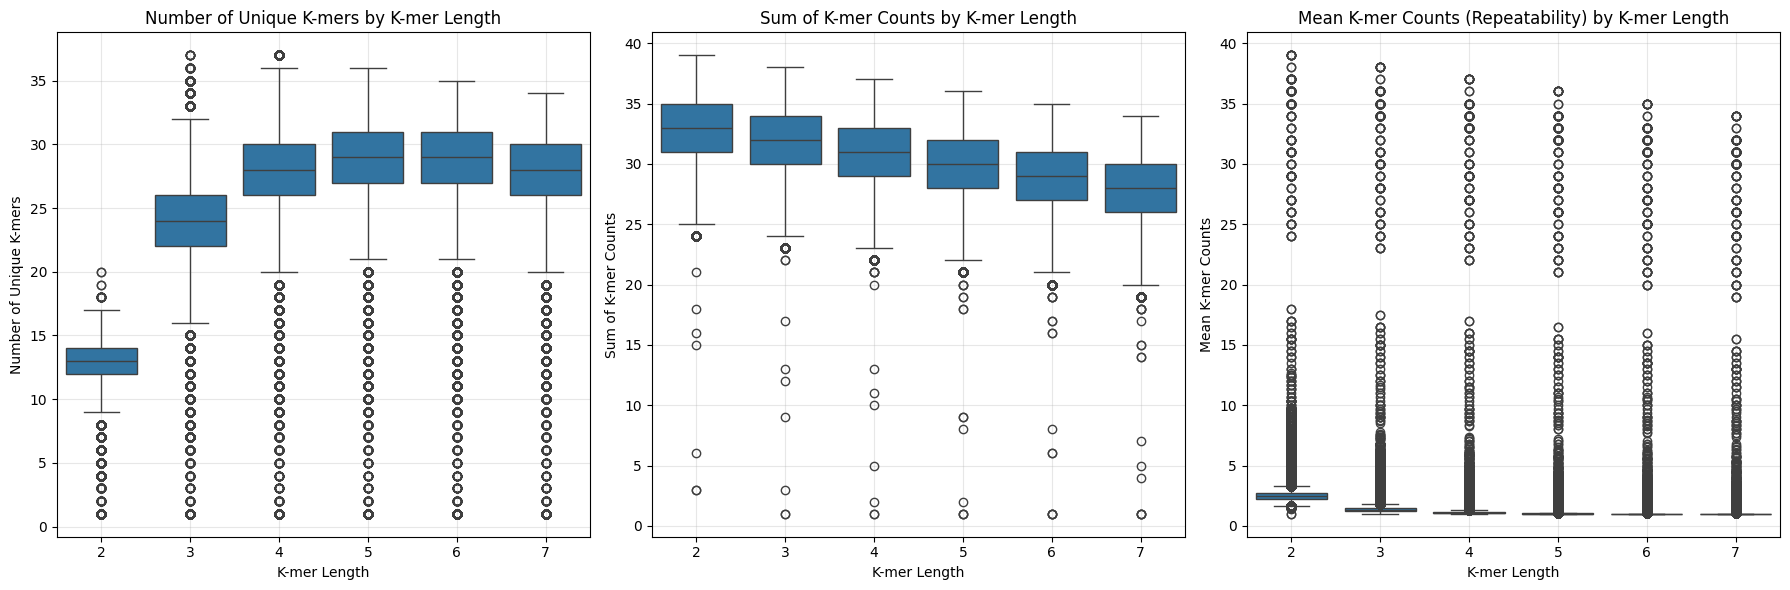

Plot saved to: /clusterfs/jgi/scratch/science/metagen/neri/code/blits/spacer_bench/results/real_data/plots/kmer_statistics_boxplots.svg


<Figure size 640x480 with 0 Axes>

In [90]:
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Number of unique k-mers
sns.boxplot(data=kmer_long, x='k_length', y='n_unique', ax=axes[0])
axes[0].set_title('Number of Unique K-mers by K-mer Length')
axes[0].set_xlabel('K-mer Length')
axes[0].set_ylabel('Number of Unique K-mers')
axes[0].grid(True, alpha=0.3)

# Plot 2: Sum of k-mer counts
sns.boxplot(data=kmer_long, x='k_length', y='sum_kmer', ax=axes[1])
axes[1].set_title('Sum of K-mer Counts by K-mer Length')
axes[1].set_xlabel('K-mer Length')
axes[1].set_ylabel('Sum of K-mer Counts')
axes[1].grid(True, alpha=0.3)

# Plot 3: Mean k-mer counts (repeatability)
sns.boxplot(data=kmer_long, x='k_length', y='mean_kmer', ax=axes[2])
axes[2].set_title('Mean K-mer Counts (Repeatability) by K-mer Length')
axes[2].set_xlabel('K-mer Length')
axes[2].set_ylabel('Mean K-mer Counts')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(f'{plots_dir}kmer_statistics_boxplots.svg', dpi=300, bbox_inches='tight')
print(f"Plot saved to: {plots_dir}kmer_statistics_boxplots.svg")


In [91]:
# Summary statistics for k-mer analysis
print("Summary statistics by k-mer length:")
print("="*50)

summary_stats = kmer_long.group_by("k_length").agg([
    pl.col("n_unique").mean().alias("mean_n_unique"),
    pl.col("n_unique").std().alias("std_n_unique"),
    pl.col("sum_kmer").mean().alias("mean_sum_kmer"),
    pl.col("sum_kmer").std().alias("std_sum_kmer"),
    pl.col("mean_kmer").mean().alias("mean_repeatability"),
    pl.col("mean_kmer").std().alias("std_repeatability")
]).sort("k_length")

print(summary_stats)

# Calculate theoretical maximum unique k-mers for each k
print("\nTheoretical maximum unique k-mers (4^k):")
for k in range(2, 8):
    max_unique = 4**k
    print(f"k={k}: {max_unique}")

# Calculate actual vs theoretical ratios
print("\nActual vs Theoretical ratios (mean):")
for k in range(2, 8):
    actual_mean = summary_stats.filter(pl.col("k_length") == k)["mean_n_unique"][0]
    theoretical_max = 4**k
    ratio = actual_mean / theoretical_max
    print(f"k={k}: {ratio:.4f} ({actual_mean:.1f}/{theoretical_max})")


Summary statistics by k-mer length:
shape: (6, 7)
┌──────────┬──────────────┬──────────────┬──────────────┬──────────────┬─────────────┬─────────────┐
│ k_length ┆ mean_n_uniqu ┆ std_n_unique ┆ mean_sum_kme ┆ std_sum_kmer ┆ mean_repeat ┆ std_repeata │
│ ---      ┆ e            ┆ ---          ┆ r            ┆ ---          ┆ ability     ┆ bility      │
│ i32      ┆ ---          ┆ f64          ┆ ---          ┆ f64          ┆ ---         ┆ ---         │
│          ┆ f64          ┆              ┆ f64          ┆              ┆ f64         ┆ f64         │
╞══════════╪══════════════╪══════════════╪══════════════╪══════════════╪═════════════╪═════════════╡
│ 2        ┆ 13.181125    ┆ 1.603478     ┆ 32.850961    ┆ 2.838648     ┆ 2.530233    ┆ 0.446301    │
│ 3        ┆ 23.554717    ┆ 3.288511     ┆ 31.850947    ┆ 2.838695     ┆ 1.375964    ┆ 0.313012    │
│ 4        ┆ 28.053252    ┆ 3.307944     ┆ 30.850939    ┆ 2.838717     ┆ 1.110039    ┆ 0.258401    │
│ 5        ┆ 28.93481     ┆ 3.082219     

For comparisson, we'll simulate 1M spacers of the same length and GC range via our rust_simulater 

In [ ]:
%%bash
spacer_bencher simulate --sample_size_spacers 1000000 --spacer_length_range 25 40 --output_dir simulated_spacers
(spacer_matching_bench) ➜  spacer_bench git:(main) ✗ spacer_bencher simulate --help 
usage: simulate [-h] [-cl CONTIG_LENGTH_RANGE CONTIG_LENGTH_RANGE] [-nc SAMPLE_SIZE_CONTIGS] [-ns SAMPLE_SIZE_SPACERS] [-ls SPACER_LENGTH_RANGE SPACER_LENGTH_RANGE] [-lm N_MISMATCH_RANGE N_MISMATCH_RANGE]
                [-ir INSERTION_RANGE INSERTION_RANGE] [-nir N_INSERTION_RANGE N_INSERTION_RANGE] [-ndr N_DELETION_RANGE N_DELETION_RANGE] [-prc PROP_RC] [-t THREADS] [-c CONTIGS] [-s SPACERS] [-id ID_PREFIX]
                [-o OUTPUT_DIR]
Length range: 25 - 40
Length mean: 33.85102008544323
GC content range: 0.025 - 0.9743589743589743
GC content mean: 0.476438028374395

Generate simulated sequences (contigs and spacers) with ground truth

optional arguments:
  -h, --help            show this help message and exit
  -cl CONTIG_LENGTH_RANGE CONTIG_LENGTH_RANGE, --contig_length_range CONTIG_LENGTH_RANGE CONTIG_LENGTH_RANGE
                        Range of contig lengths
  -nc SAMPLE_SIZE_CONTIGS, --sample_size_contigs SAMPLE_SIZE_CONTIGS
                        Number of contigs to generate
  -ns SAMPLE_SIZE_SPACERS, --sample_size_spacers SAMPLE_SIZE_SPACERS
                        Number of spacers to generate
  -ls SPACER_LENGTH_RANGE SPACER_LENGTH_RANGE, --spacer_length_range SPACER_LENGTH_RANGE SPACER_LENGTH_RANGE
                        Range of spacer lengths
  -lm N_MISMATCH_RANGE N_MISMATCH_RANGE, --n_mismatch_range N_MISMATCH_RANGE N_MISMATCH_RANGE
                        Range of number of mismatches
  -ir INSERTION_RANGE INSERTION_RANGE, --insertion_range INSERTION_RANGE INSERTION_RANGE
                        Range of number of insertions per contig
  -nir N_INSERTION_RANGE N_INSERTION_RANGE, --n_insertion_range N_INSERTION_RANGE N_INSERTION_RANGE
                        Range of number of insertions within spacer sequences
  -ndr N_DELETION_RANGE N_DELETION_RANGE, --n_deletion_range N_DELETION_RANGE N_DELETION_RANGE
                        Range of number of deletions within spacer sequences
  -prc PROP_RC, --prop_rc PROP_RC
                        Proportion of spacers to reverse complement
  -t THREADS, --threads THREADS
                        Number threads
  -c CONTIGS, --contigs CONTIGS
                        Path to contigs file (if not provided, will generate simulated data)
  -s SPACERS, --spacers SPACERS
                        Path to spacers file (if not provided, will generate simulated data)
  -id ID_PREFIX, --id_prefix ID_PREFIX
                        Prefix for sequence IDs (default is hash of parameters)
  -o OUTPUT_DIR, --output_dir OUTPUT_DIR
                        Output directory for simulated data (default: auto-generated based on parameters)

contigs
crispr-host-prediction
spacer_df.parquet
spacers


### "Dust" masking


Adding a column for the number of masked bases in a spacer when using pydustmasker with a window size of 5 and a score threshold of 6.

In [ ]:
spacer_df = spacer_df.with_columns(
    pl.col("seq").map_elements(lambda x: pdm.DustMasker(x, window_size=20, score_threshold=16).n_masked_bases, return_dtype=pl.Int64).alias("low_compx_n_masked")
    )
spacer_df["low_compx_n_masked"].value_counts().sort(by="low_compx_n_masked", descending=True)

low_compx_n_masked,count
i64,u32
40,3
39,3
38,6
37,6
36,10
…,…
9,1847
8,8713
7,35546


In [ ]:
low_compx_spacers = spacer_df.filter(pl.col("low_compx_n_masked") > 0)
low_compx_spacers


seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,0.420026,24
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,0.76651,20
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,0.76651,28
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,0.578795,29
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,0.613619,27
…,…,…,…,…,…,…,…,…,…
"""GCF_924101635.2:NZ_CAKMAA02000…","""AGGAAAAAAGCGCCAAGCGCGAGACCAGCA…",34,0.0,0.411765,0.0,0.264706,0.323529,1.561403,6
"""3300008130_20:Ga0114850_100045…","""AACACCGACAGCGACAAAAAAACGACAACG…",35,0.0,0.542857,0.0,0.285714,0.171429,1.431006,7
"""GCF_963666145.1:NZ_OY762614.1:…","""CCCCGGAAGAGAGAGAGAGAGAGCGCGAGA…",34,0.0,0.382353,0.0,0.176471,0.441176,1.492791,27


In [ ]:
high_compx_spacers = spacer_df.filter(pl.col("low_compx_n_masked") == 0)
high_compx_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000124313:MGYG000124313_31…","""TCTTTCTTTTTCTTTGTTTCTTTCTTTTTC""",30,0.0,0.0,0.766667,0.2,0.033333,0.921834,0
"""MGYG000222119:MGYG000222119_2:…","""TTTCTTCTTTTTCTTCTGATTTTTCTATTG…",35,0.0,0.057143,0.742857,0.142857,0.057143,1.191538,0
"""MGYG000205949:MGYG000205949_50…","""TTATATTTGTTATTTTTATTCTTTTAATTT…",31,0.0,0.193548,0.741935,0.032258,0.032258,1.09769,0
"""GCA_028719245.1:JAQUKG01000007…","""TTTTTCTTATTTCATTTTCTTTGATTT""",27,0.0,0.111111,0.740741,0.111111,0.037037,1.201245,0
"""3300029595_16:Ga0245140_101222…","""TTTTCATTTTTAATTTCTTTCATTTCTTTT""",30,0.0,0.133333,0.733333,0.133333,0.0,1.103307,0
…,…,…,…,…,…,…,…,…,…
"""GCF_964211445.1:NZ_CAXOQT01000…","""CCAACCCGCAGCCCACGCACCGGCAGCAGA…",32,0.0,0.25,0.0,0.5,0.25,1.5,0
"""GCF_964211445.1:NZ_CAXOQT01000…","""GCCAACCCGCAGCCCACGCACCGGCAGCAG…",33,0.0,0.242424,0.0,0.484848,0.272727,1.513202,0
"""MGYG000058057:MGYG000058057_89…","""AAAGAACCCAAAGAACCGAAGGAGGAGCCA…",33,0.0,0.515152,0.0,0.212121,0.272727,1.478707,0


In [ ]:
low_entropy_spacers = spacer_df.filter(pl.col("entropy") <= 1.4)
low_entropy_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,0.420026,24
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,0.76651,20
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,0.76651,28
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,0.578795,29
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,0.613619,27
…,…,…,…,…,…,…,…,…,…
"""GCF_934476685.1:NZ_CAKSNX01000…","""GAGCGGAGCGCAGGGGCGAGGGGGAGCAGA…",34,0.0,0.235294,0.0,0.176471,0.588235,1.3831,0
"""MGYG000304187:MGYG000304187_9:…","""AGAAGAAAAAGAGACACCAGAAGAGCAGGA…",34,0.0,0.558824,0.0,0.147059,0.294118,1.395123,0
"""GCF_964023245.1:NZ_OZ026884.1:…","""CGCCCCAGCCGCCGCCCCCGGAGCCCGGCC…",35,0.0,0.114286,0.0,0.6,0.285714,1.316199,0


In [ ]:
low_entropy_spacers = high_compx_spacers.filter(pl.col("entropy") <= 1.4)
low_entropy_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,f64,i64
"""MGYG000124313:MGYG000124313_31…","""TCTTTCTTTTTCTTTGTTTCTTTCTTTTTC""",30,0.0,0.0,0.766667,0.2,0.033333,0.921834,0
"""MGYG000222119:MGYG000222119_2:…","""TTTCTTCTTTTTCTTCTGATTTTTCTATTG…",35,0.0,0.057143,0.742857,0.142857,0.057143,1.191538,0
"""MGYG000205949:MGYG000205949_50…","""TTATATTTGTTATTTTTATTCTTTTAATTT…",31,0.0,0.193548,0.741935,0.032258,0.032258,1.09769,0
"""GCA_028719245.1:JAQUKG01000007…","""TTTTTCTTATTTCATTTTCTTTGATTT""",27,0.0,0.111111,0.740741,0.111111,0.037037,1.201245,0
"""3300029595_16:Ga0245140_101222…","""TTTTCATTTTTAATTTCTTTCATTTCTTTT""",30,0.0,0.133333,0.733333,0.133333,0.0,1.103307,0
…,…,…,…,…,…,…,…,…,…
"""MGYG000334016:MGYG000334016_12…","""NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",37,1.0,0.0,0.0,0.0,0.0,0.0,0
"""GCF_934476685.1:NZ_CAKSNX01000…","""GAGCGGAGCGCAGGGGCGAGGGGGAGCAGA…",34,0.0,0.235294,0.0,0.176471,0.588235,1.3831,0
"""MGYG000304187:MGYG000304187_9:…","""AGAAGAAAAAGAGACACCAGAAGAGCAGGA…",34,0.0,0.558824,0.0,0.147059,0.294118,1.395123,0


In [ ]:
N_spacers = spacer_df.filter(pl.col("n_frac") > 0)
N_spacers

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,low_compx_n_masked
str,str,u32,f64,f64,f64,f64,f64,i64
"""GCA_019561555.1:JAHEQB01000003…","""TTTTTTTATCACCTTTTAAAGATTTTTAAG…",38,0.026316,0.236842,0.605263,0.078947,0.052632,18
"""GCA_019561555.1:JAHEQB01000003…","""TTTTTTATCACCTTTTAAAGATTTTTAAGN…",37,0.027027,0.243243,0.594595,0.081081,0.054054,17
"""GCA_003483675.1:DMYK01000440.1…","""TGCTTCTTCTATTTGTTGTTTACGTTGTGN…",31,0.064516,0.064516,0.548387,0.129032,0.193548,0
"""GCA_020692945.1:JAIMJY01000008…","""TATATTTTATATTTTATTTTTATNNNNNNN…",34,0.323529,0.176471,0.5,0.0,0.0,5
"""GCA_016841625.1:JAENYU01000001…","""TTACTTTTTTNNNNNNNNNNTTTCCTTTAC…",31,0.322581,0.064516,0.483871,0.129032,0.0,6
…,…,…,…,…,…,…,…,…
"""MGYG000051310:MGYG000051310_92…","""NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",36,1.0,0.0,0.0,0.0,0.0,0
"""GCF_900129055.1:NZ_FQUZ0100002…","""GAGGAANNNNNNNNNNNNNNNNNNNNNNNN…",32,0.78125,0.09375,0.0,0.0,0.125,0
"""GCF_900230225.1:NZ_OCNH0100000…","""CNNNNNNNNNNNNNNNNNNNNNNNNNNNNN…",36,0.944444,0.0,0.0,0.055556,0.0,0


Will use LCC from biopython (https://github.com/biopython/biopython/blob/e451db211bdd855a5d0f1f6bba18985ffee12696/Bio/SeqUtils/lcc.py)

In [ ]:
testdf = spacer_df.head(12116)
testdf = testdf.with_columns(
    pl.col("seq").map_elements(lambda x: lcc_simp(x), return_dtype=pl.Float64).alias("lcc")
)
testdf["lcc"].describe()
# testdf.filter(pl.col("lcc") < 0)
# testdf.filter(pl.col("lcc") < 0).head(3)


statistic,value
str,f64
"""count""",12116.0
"""null_count""",0.0
"""mean""",0.727165
"""std""",0.063331
"""min""",0.210013
"""25%""",0.695491
"""50%""",0.741916
"""75%""",0.772576
"""max""",0.813469


In [ ]:
import kcounter
def test_kmer(seq):
	flag = ""
	# print(f"SEQ ==> {seq}")
	if "N" in seq or "n" in seq:
		flag = "low_complexity_N"
	else:
		for i in range(8,1,-1):
			counts = list(kcounter.count_kmers(seq, i, canonical_kmers=False).values())
			# print(f"\t{counts}")
			max_c = max(counts)
			ratio = max_c / sum(counts)
			# print(f"{seq} // {i} // {max(counts)} // {sum(counts)} // {ratio} // {counts}")
			# if ratio > 0.3: ## Most frequent k-mer above 30%, we flag
			### Empirical thresholds for now
			if i>=6 and max_c>=2: ## most frequent kmer is found twice or more for k=6, 7, or 8 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==5 and max_c>=3: ## most frequent kmer is found three times or more for k=5 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==4 and ratio>=0.15: ## most frequent kmer is found at a frequency above 15% for k=4 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==3 and ratio>=0.2: ## most frequent kmer is found at a frequency above 20% for k=3 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
			elif i==2 and ratio>=0.3: ## most frequent kmer is found at a frequency above 30% for k=2 -> we flag
				flag = "low_complexity_kmer" + str(i)
				break
	return flag
kcounter.count_kmers("ATGCTGG",5)

{'TGCTG': 1.0, 'GCTGG': 1.0, 'ATGCT': 1.0}

In [ ]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    (pl.col("seq").map_elements(lambda x: kcounter.count_kmers(x, 6, canonical_kmers=False).values(),return_dtype=pl.List(pl.Float32)).alias("6mer_counts"))
)
type((test_df["6mer_counts"].item(1)))
(test_df["6mer_counts"].item(1))
test_df

seqid,seq,length,n_frac,a_frac,t_frac,c_frac,g_frac,entropy,low_compx_n_masked,6mer_counts
str,str,u32,f64,f64,f64,f64,f64,f64,i64,list[f32]
"""MGYG000215836:MGYG000215836_17…","""TTGTTATTTTTTTTTTTTTTTTTTTTTTTT""",30,0.0,0.033333,0.933333,0.0,0.033333,0.420026,24,"[1.0, 1.0, … 1.0]"
"""MGYG000284124:MGYG000284124_95…","""TTTTCTTTCGTTTTTTATTTTTTTTTTTTT""",30,0.0,0.033333,0.866667,0.066667,0.033333,0.76651,20,"[1.0, 1.0, … 1.0]"
"""MGYG000084070:MGYG000084070_1:…","""TGTTTTTTTTTTTGTTTTTACTTTTTTTTT""",30,0.0,0.033333,0.866667,0.033333,0.066667,0.76651,28,"[10.0, 1.0, … 1.0]"
"""MGYG000293011:MGYG000293011_47…","""TTATTTTTTATTTATTTTTTTATTTTTTT""",29,0.0,0.137931,0.862069,0.0,0.0,0.578795,29,"[1.0, 3.0, … 3.0]"
"""3300017688_7:Ga0180017_100481:…","""TTTTTTTTTCCTCTTTTTTTTTTTTTTCTT…",33,0.0,0.0,0.848485,0.151515,0.0,0.613619,27,"[1.0, 1.0, … 2.0]"
…,…,…,…,…,…,…,…,…,…,…
"""GCF_001601575.1:NZ_LOHZ0100002…","""GTTACTTCTTTTATTTTGAACGATGCCGCC…",37,0.0,0.135135,0.486486,0.243243,0.135135,1.78223,0,"[1.0, 1.0, … 1.0]"
"""GCF_001601575.1:NZ_LOHZ0100002…","""TCAAGTAAATTCTTTGGTTTTGATATTATC…",37,0.0,0.297297,0.486486,0.108108,0.108108,1.719929,0,"[1.0, 1.0, … 1.0]"
"""GCF_001601575.1:NZ_LOHZ0100002…","""GATGAAAAAATTGTTTTTACTATCGTTGGT…",37,0.0,0.297297,0.486486,0.054054,0.162162,1.679124,6,"[1.0, 1.0, … 1.0]"


In [ ]:
plt.hist(spacer_df['entropy'], bins=100, edgecolor='black')

In [ ]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    pl.col("seq")
    .str.count_matches("A|C|G|T|N")
    .list.eval(pl.element().value_counts()) # The new way
    .alias("char_counts")
)

test_df
# test_df.unnest("char_counts")

InvalidOperationError: list.eval operation not supported for dtype `u32`

In [ ]:
# TODO: compare or test using this from bbtools:
# # kmercountshort.sh in=file.fa out=kcount.tsv k=5 skip=5 

In [ ]:
test_df = spacer_df.head(100000)
test_df = test_df.with_columns(
    pl.col("seq").str.split("").alias("character")
).group_by("character").len()
test_df

AttributeError: 'Expr' object has no attribute 'count_by'

In [ ]:
from collections import defaultdict
def count_kmers_defdict_python(seq: str, k: int, relative: bool = False) -> dict:
    if not seq or len(seq) < k:
        return {}
    kmers = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i : i + k].upper()
        if "N" not in kmer:
            kmers[kmer] += 1
    total = sum(kmers.values())
    return {k: v / total if relative else v for k, v in kmers.items()} if total > 0 else {}



(Next steps are in the subsampling notebook)

We'll further curate the spacer set by filtering out very low complexity sequences:  
- no more than 10% of the spacer is Ns
- no 6mers found more than 3 times.
- no 5mers found more than 5 times.
- All bases are A, T, C, or G must be present.
- Shannon entropy > 0.5
- pydustmasker with a window size of 5 and a score threshold of 18 has no masked bases.
